# Práctica 2
## Parte 1. Análisis de sentimientos 
<br>

__Alumnos:__
* __Frederick Ernesto Borges Noronha__
* __Victor Manuel Cavero Gracia__

### Apartado A.

Configura una partición train-test usando el 75% de los datos para entrenamiento y el 25% restante para test.

Vamos a estudiar varias representaciones de bolsa de palabras, pero todas ellas utilizarán __countVectorizer__ con el diccionario que se crea a partir de los términos del propio corpus y la lista de palabras vacías (__stop_words__) que proporciona sklearn para el inglés. Las 4 posibilidades que estudiaremos surgen de combinar los siguientes 2 parámetros:

* Bolsa de palabras binaria y bolsa de palabras con TF/IDF (parámetro binary).
* Usando un rango de n-gramas de (1,1) y de (1,2) (parámetro __ngram_range__).

Para cada una de esas 4 combinaciones entrenaremos dos clasificadores:

1. Un clasificador naive bayes, eligiendo el más adecuado para cada caso.
2. Un árbol de decisión buscando un valor óptimo para uno de los siguientes parámetros para que se maximice la tasa de aciertos en el conjunto de test: __max_depth__, __min_samples_leaf__ o __max_leaf_nodes__ (siempre el mismo).

Analiza la tasa de aciertos de entrenamiento y test de los 2 clasificadores en las 4 representaciones de bolsa de palabras (8 configuraciones en total) y contesta a las siguientes preguntas:

* ¿Hay un clasificador que sea superior al otro? ¿por qué crees que sucede?
* Para cada clasificador, ¿tiene un efecto positivo el añadir “complejidad” a la vectorización? Es decir, añadir bigramas y añadir tf-idf. ¿Por qué crees que sucede este efecto positivo o la falta del mismo?

Selecciona el mejor árbol de decisión y obtén las 25 variables con más poder discriminante:

* ¿Predominan más las palabras de uno u otro sentimiento? ¿por qué? ¿hay ruido?

Selecciona el mejor clasificador naive bayes y obtén las 25 variables con más presencia en cada clase:

* ¿Tienen sentido las palabras seleccionadas? ¿hay ruido (palabras sin sentimiento o de sentimiento opuesto al esperado)? ¿por qué crees que suceden estos fenómenos?

Finalmente, explica de manera razonada las conclusiones que has extraído de todo el estudio realizado en este apartado.

### Apartado B.

Toma el mejor clasificador Naive Bayes y el mejor árbol de decisión y analiza a fondo sus resultados en el conjunto de test.
1. Analiza la precisión y la exhaustividad de cada clasificador en cada una de las clases (opiniones positivas y negativas).
    * Para cada clasificador, ¿tiene un comportamiento homogéneo a la hora de clasificar ambas clases?
    * ¿Cuáles son las fortalezas y debilidades de cada uno de los clasificadores?
    * ¿Hay algún clasificador que sea mejor que el otro en todo?
    * ¿Coinciden ambos clasificadores a la hora de clasificar mejor una clase que la otra?

2. Pinta los 8 primeros niveles del árbol de decisión y comenta lo que ves.
    * ¿Qué estructura tiene el árbol?
    * ¿Cómo interpretas los niveles que has pintado? ¿tienen algún sentido con respecto a la tasa de aciertos, o la precisión y exhaustividad del clasificador? o ¿Hay nodos impuros?
    
3. Por cada clasificador identifica 2 críticas que hayan sido falsas positivas (malas críticas calificadas como buenas) y 2 críticas que han sido falsas negativas (buenas críticas clasificadas como malas). Analiza tanto su texto original, como el vector de palabras resultante (solamente los términos activos).
    * ¿Por qué crees que ha fallado el clasificador en cada uno de los casos?
    * ¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?

### Imports:
A continuación se encuentran todos los imports de las librerias de las que haremos uso en esta práctica.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Apartado A.

In [4]:
# Read the dataset
data = pd.read_csv('Datos/yelp_labelled.txt', sep="\t", header=None)
train, test = tts(data, train_size=0.75, test_size=0.25, random_state=42)

In [3]:
# Show the data
data

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [4]:
# Show the train data
train

,0,1
82,The turkey and roast beef were bland.,0
991,Spend your money and time some place else.,0
789,"Great atmosphere, friendly and fast service.",1
894,If you stay in Vegas you must get breakfast he...,1
398,Service is perfect and the family atmosphere i...,1
...,...,...
106,"The food was delicious, our bartender was atte...",1
270,The Veggitarian platter is out of this world!,1
860,"This place is pretty good, nice little vibe in...",1
435,It was a huge awkward 1.5lb piece of cow that ...,0


In [5]:
# Show the test data
test

,0,1
521,If you haven't gone here GO NOW!,1
737,Try them in the airport to experience some tas...,1
740,The restaurant is very clean and has a family ...,1
660,"I personally love the hummus, pita, baklava, f...",1
411,"Come hungry, leave happy and stuffed!",1
...,...,...
109,Sooooo good!!,1
430,I never come again.,0
77,The sweet potato fries were very good and seas...,1
84,The pan cakes everyone are raving about taste ...,0


Como podemos observar teniamos __1000 filas__ en los `datos iniciales` y al generar las particiones de train y test se obtienen un conjunto de `train` de __750 filas__ (75%) y otro de`test` de __250 filas__ (25%).

In [5]:
vectorizer = CountVectorizer(stop_words='english')
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(train[0])

In [7]:
feature_names = vectorizer.get_feature_names()

print(feature_names)
print("Feature_names Length", len(feature_names))

['10', '100', '12', '17', '1979', '20', '2007', '30', '30s', '35', '40', '40min', '45', '4ths', '5lb', '70', '85', '90', 'absolute', 'absolutely', 'absolutley', 'accident', 'accomodate', 'accordingly', 'accountant', 'acknowledged', 'actual', 'actually', 'added', 'affordable', 'afternoon', 'ago', 'ahead', 'airline', 'ala', 'allergy', 'amazing', 'ambiance', 'ambience', 'ample', 'andddd', 'angry', 'anymore', 'anytime', 'anyways', 'apart', 'apologize', 'apology', 'app', 'appalling', 'apparently', 'appealing', 'appetite', 'appetizer', 'appetizers', 'apple', 'area', 'aren', 'arepas', 'aria', 'array', 'arrived', 'arrives', 'arriving', 'ask', 'asked', 'asking', 'assure', 'ate', 'atmosphere', 'attached', 'attack', 'attention', 'attentive', 'attitudes', 'auju', 'authentic', 'average', 'avocado', 'avoid', 'avoided', 'away', 'awesome', 'awful', 'awkward', 'awkwardly', 'baby', 'bacon', 'bad', 'bagels', 'bakery', 'bamboo', 'bar', 'bare', 'barely', 'bargain', 'bartender', 'bartenders', 'baseball', 'b

La lista de palabras que se utilizará para realizar el analisis de sentimientos contienen `1523 palabras`.

### Clasificador Naive Bayes

Para poder realizar un análisis de los resultados posteriores debemos calcular un Naive Bayes sin ninguno de los parametros que estamos ajustando (`binary` y `ngram_range`).

Estos parametros tienen los siguientes valores por defecto:
* `binary`. Por defecto: __False__.

* `ngram_range`. Por defecto: __(1, 1)__.

In [8]:
vectorizer0 = CountVectorizer(stop_words='english')

train_vector_data0 = vectorizer0.fit_transform(train[0])
test_vector_data0 = vectorizer.transform(test[0])

In [9]:
mnb_classifier0 = MultinomialNB()

mnb_classifier0.fit(train_vector_data0, train[1])

mnb_train_predictions0 = mnb_classifier0.predict(train_vector_data0)
mnb_test_predictions0 = mnb_classifier0.predict(test_vector_data0)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions0 == train[1]))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions0 == test[1]))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.952
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.764


- __Bolsa de palabras binaria con Monogramas:__ (Código NB1)

In [10]:
vectorizer1 = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,1))

train_vector_data1 = vectorizer1.fit_transform(train[0])
test_vector_data1 = vectorizer1.transform(test[0])

In [11]:
mnb_classifier1 = MultinomialNB()

mnb_classifier1.fit(train_vector_data1, train[1])

mnb_train_predictions1 = mnb_classifier1.predict(train_vector_data1)
mnb_test_predictions1 = mnb_classifier1.predict(test_vector_data1)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions1 == train[1]))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions1 == test[1]))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9506666666666667
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.764


In [12]:
labels = ['NB1']
train_means = [np.mean(mnb_train_predictions1 == train[1]) * 100]
test_means = [np.mean(mnb_test_predictions1 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

|<center>PARTICIÓN</center>|<center>REF</center>|<center>NB1</center>|
|---------|---|---|
|<center>**Train**</center>|<center>0.952</center>|<center>0.9506666666666667</center>|
|<center>**Test**</center>|<center>0.764</center>|<center>0.764</center>|

Como podemos observar, añadir los parametros para que funcione con bolsa de palabras binaria (`binary=True`) y con monogramas (`ngram_range=(1,1)`, esto no añade complejidad ya que es igual que el parametro por defecto), no producen una mejora en el resultado numérico, por lo contrario empeora la tasa de aciertos en test, pero no indica que sea un mal resultado, ya que quizas con esta implemetación se estan aprendiendo reglas que no correctas.

- __Bolsa de palabras binaria con Monogramas y Bigramas:__ (Código NB2)

In [13]:
vectorizer2 = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,2))

train_vector_data2 = vectorizer2.fit_transform(train[0])
test_vector_data2 = vectorizer2.transform(test[0])

In [14]:
mnb_classifier2 = MultinomialNB()

mnb_classifier2.fit(train_vector_data2, train[1])

mnb_train_predictions2 = mnb_classifier2.predict(train_vector_data2)
mnb_test_predictions2 = mnb_classifier2.predict(test_vector_data2)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions2 == train[1]))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions2 == test[1]))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9773333333333334
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.772


In [15]:
labels = labels + ['NB2']
train_means = train_means + [np.mean(mnb_train_predictions2 == train[1]) * 100]
test_means = test_means + [np.mean(mnb_test_predictions2 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

|<center>PARTICIÓN</center>|<center>REF</center>|<center>NB2</center>|
|---------|---|---|
|<center>**Train**</center>|<center>0.952</center>|<center>0.9773333333333334</center>|
|<center>**Test**</center>|<center>0.764</center>|<center>0.772</center>|

Como podemos observar, añadir los parametros para que funcione con bolsa de palabras binaria (`binary=True`) y con monogramas y bigramas (`ngram_range=(1,2)`), ofrece una diferencia en el porcentaje de aciertos tanto en el conjunto de train como en el conjunto de test.

Esto viene dado porque se usa la hipotesis de Markov para calcular la frecuenta de los bigramas y esto hace que los calculos realizados sean mas precisos que solo evaluar una palabra en un contexto determinado.

- __Bolsa de palabras con TF/IDF con Monogramas:__ (Código NB3)

In [16]:
vectorizer3 = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1))

train_vector_data3=vectorizer3.fit_transform(train[0])

tfidfer3= TfidfTransformer()

# Calculamos el valor TF-IDF 
train_preprocessed3=tfidfer3.fit_transform(train_vector_data3)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data3=vectorizer3.transform(test[0])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed3=tfidfer3.transform(test_vector_data3)

In [17]:
mnb_classifier3 = MultinomialNB()

mnb_classifier3.fit(train_preprocessed3, train[1])

mnb_train_predictions3 = mnb_classifier3.predict(train_preprocessed3)
mnb_test_predictions3 = mnb_classifier3.predict(test_preprocessed3)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions3 == train[1]))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions3 == test[1]))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9613333333333334
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.772


In [18]:
labels = labels + ['NB3']
train_means = train_means + [np.mean(mnb_train_predictions3 == train[1]) * 100]
test_means = test_means + [np.mean(mnb_test_predictions3 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

|<center>PARTICIÓN</center>|<center>REF</center>|<center>NB3</center>|
|---------|---|---|
|<center>**Train**</center>|<center>0.952</center>|<center>0.9613333333333334</center>|
|<center>**Test**</center>|<center>0.764</center>|<center>0.772</center>|

Como podemos observar, añadir los parametros para que funcione con bolsa de palabras con TF/IDF (`binary=False`) y con monogramas (`ngram_range=(1,1)`), ofrece una diferencia en el porcentaje de aciertos tanto en el conjunto de train como en el conjunto de test.

Esto se debe al que al calcular con TF/IDF la bolsa de palabras la importancia de una palabra sea inversamente relativa a lo común que es en el documento, por tanto se obtiene una mejora en el clasificador.

- __Bolsa de palabras con TF/IDF con Monogramas y Bigramas:__ (Código NB4)

In [6]:
vectorizer4 = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,2))

train_vector_data4 = vectorizer4.fit_transform(train[0])

tfidfer4 = TfidfTransformer()

# Calculamos el valor TF-IDF 
train_preprocessed4 = tfidfer4.fit_transform(train_vector_data4)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data4 = vectorizer4.transform(test[0])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed4 = tfidfer4.transform(test_vector_data4)

In [7]:
mnb_classifier4 = MultinomialNB()

mnb_classifier4.fit(train_preprocessed4, train[1])

mnb_train_predictions4 = mnb_classifier4.predict(train_preprocessed4)
mnb_test_predictions4 = mnb_classifier4.predict(test_preprocessed4)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions4 == train[1]))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions4 == test[1]))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9893333333333333
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.784


In [21]:
labels = labels + ['NB4']
train_means = train_means + [np.mean(mnb_train_predictions4 == train[1]) * 100]
test_means = test_means + [np.mean(mnb_test_predictions4 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

|<center>PARTICIÓN</center>|<center>REF</center>|<center>NB4</center>|
|---------|---|---|
|<center>**Train**</center>|<center>0.952</center>|<center>0.9893333333333333</center>|
|<center>**Test**</center>|<center>0.764</center>|<center>0.784</center>|

Como podemos observar, añadir los parametros para que funcione con bolsa de palabras con TF/IDF (`binary=False`) y con monogramas y bigramas (`ngram_range=(1,2)`), ofrece una diferencia en el porcentaje de aciertos tanto en el conjunto de train como en el conjunto de test.

Esto se debe al que al calcular con TF/IDF la bolsa de palabras la importancia de una palabra sea inversamente relativa a lo común que es en el documento y además al utilizar monogramas y bigramas nos aseguramos de que no se evaluen las palabras unicamente de forma individual si no que también se tome en cuenta la palabra que le precede, todo esto permite que se obtenga una mejora en el clasificador.

### Comparativa entre los clasificadores

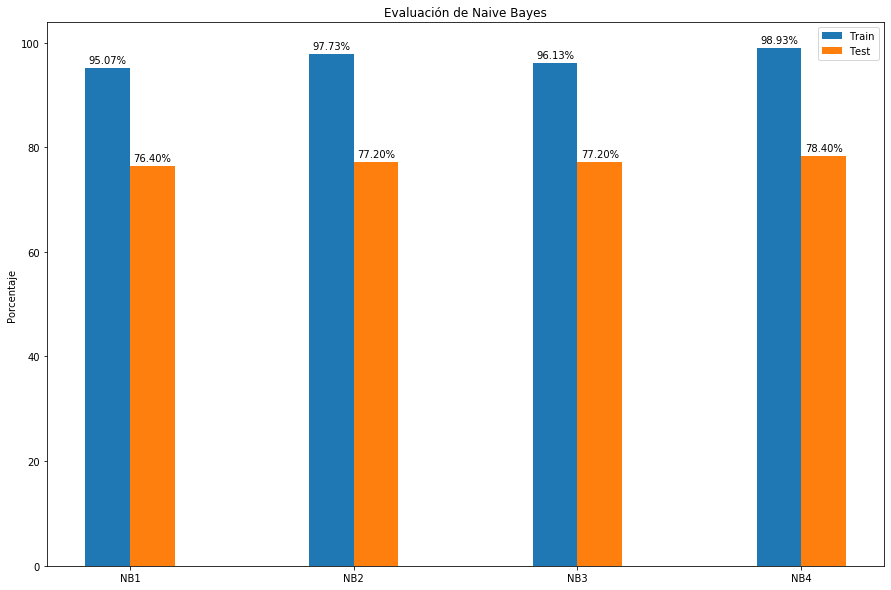

In [22]:
x = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize = (15, 10))
rects1 = ax.bar(x - width/2, train_means, width, label='Train')
rects2 = ax.bar(x + width/2, test_means, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Porcentaje')
ax.set_title('Evaluación de Naive Bayes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

__¿Hay un clasificador que sea superior al otro? ¿por qué crees que sucede?__

Como podemos apreciar en el gráfico de barras, el mejor clasificador que se tienen en Naive Bayes es el NB4 que  es el código con el que hemos llamado al clasificador con `Bolsa de palabras con TF/IDF con Monogramas y Bigramas` aunque la diferencia para los clasificadores de Naive Bayes es pequeña, pero podemos indicar el orden en el utilizariamos los mismos:

1. NB4: `Bolsa de palabras con TF/IDF con Monogramas y Bigramas`.

2. NB2: `Bolsa de palabras binaria con Monogramas y Bigramas`.

3. NB3: `Bolsa de palabras con TF/IDF con Monogramas`.

4. NB1: `Bolsa de palabras binaria con Monogramas`.

Como hemos indicado anteriormente, el clasificador que utiliza bolsa de palabras con TF/IDF junto a monogramas y bigramas, ya que es la mejor combinación evaluada y esto se debe a que la importancia de una palabra es inversamente relativa a lo común que es en el documento y no se evaluan unicamente las palabras de forma individual si no que también se toma en cuenta la palabra que le precede.

### Árbol de decisión 

In [23]:
vectorizer5 = CountVectorizer(stop_words='english')

train_vector_data5 = vectorizer5.fit_transform(train[0])
test_vector_data5 = vectorizer5.transform(test[0])

In [24]:
# Creamos el clasificador con los valores por defecto
tree_classifier0 = tree.DecisionTreeClassifier(random_state=42)
tree_classifier0.fit(train_vector_data5, train[1])

tree_train_predictions0 = tree_classifier0.predict(train_vector_data5)
tree_test_predictions0 = tree_classifier0.predict(test_vector_data5)


print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions0 == train[1]))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions0 == test[1]))

Árbol, porcentaje de aciertos en entrenamiento: 0.9973333333333333
Árbol, porcentaje de aciertos en test: 0.664


- __Bolsa de palabras binaria con Monogramas:__ (Código AD1)

In [25]:
vectorizer6 = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,1))

train_vector_data6 = vectorizer6.fit_transform(train[0])
test_vector_data6 = vectorizer6.transform(test[0])

In [26]:
# Creamos el clasificador con los valores por defecto
tree_classifier1 = tree.DecisionTreeClassifier(random_state=42)
tree_classifier1.fit(train_vector_data6, train[1])

tree_train_predictions1 = tree_classifier1.predict(train_vector_data6)
tree_test_predictions1 = tree_classifier1.predict(test_vector_data6)


print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions1 == train[1]))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions1 == test[1]))

Árbol, porcentaje de aciertos en entrenamiento: 0.9973333333333333
Árbol, porcentaje de aciertos en test: 0.672


In [27]:
labels2 = ['AD1']
train_means2 = [np.mean(tree_train_predictions1 == train[1]) * 100]
test_means2 = [np.mean(tree_test_predictions1 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

`RESPUESTA PENDIENTE`

- __Bolsa de palabras binaria con Monogramas y Bigramas:__ (Código AD2)

In [28]:
vectorizer7 = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,2))

train_vector_data7 = vectorizer7.fit_transform(train[0])
test_vector_data7 = vectorizer7.transform(test[0])

In [29]:
# Creamos el clasificador con los valores por defecto
tree_classifier2 = tree.DecisionTreeClassifier(random_state=42)
tree_classifier2.fit(train_vector_data7, train[1])

tree_train_predictions2 = tree_classifier2.predict(train_vector_data7)
tree_test_predictions2 = tree_classifier2.predict(test_vector_data7)


print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions2 == train[1]))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions2 == test[1]))

Árbol, porcentaje de aciertos en entrenamiento: 0.9973333333333333
Árbol, porcentaje de aciertos en test: 0.672


In [30]:
labels2 = labels2 + ['AD2']
train_means2 = train_means2 + [np.mean(tree_train_predictions2 == train[1]) * 100]
test_means2 = test_means2 + [np.mean(tree_test_predictions2 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

`RESPUESTA PENDIENTE`

- __Bolsa de palabras con TF/IDF con Monogramas:__ (Código AD3)

In [25]:
vectorizer8 = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1))

train_vector_data8=vectorizer8.fit_transform(train[0])

tfidfer8= TfidfTransformer()

# Calculamos el valor TF-IDF 
train_preprocessed8=tfidfer8.fit_transform(train_vector_data8)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data8=vectorizer8.transform(test[0])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed8=tfidfer8.transform(test_vector_data8)

In [26]:
# Creamos el clasificador con los valores por defecto
tree_classifier3 = tree.DecisionTreeClassifier(random_state=42)
tree_classifier3.fit(train_preprocessed8, train[1])

tree_train_predictions3 = tree_classifier3.predict(train_preprocessed8)
tree_test_predictions3 = tree_classifier3.predict(test_preprocessed8)


print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions3 == train[1]))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions3 == test[1]))

Árbol, porcentaje de aciertos en entrenamiento: 0.9973333333333333
Árbol, porcentaje de aciertos en test: 0.696


In [33]:
labels2 = labels2 + ['AD3']
train_means2 = train_means2 + [np.mean(tree_train_predictions3 == train[1]) * 100]
test_means2 = test_means2 + [np.mean(tree_test_predictions3 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

`RESPUESTA PENDIENTE`

- __Bolsa de palabras con TF/IDF con Monogramas y Bigramas:__ (Código AD4)

In [34]:
vectorizer9 = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,2))

train_vector_data9 = vectorizer9.fit_transform(train[0])

tfidfer9 = TfidfTransformer()

# Calculamos el valor TF-IDF 
train_preprocessed9 = tfidfer9.fit_transform(train_vector_data9)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data9 = vectorizer9.transform(test[0])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed9 = tfidfer9.transform(test_vector_data4)

In [35]:
# Creamos el clasificador con los valores por defecto
tree_classifier4 = tree.DecisionTreeClassifier(random_state=42)
tree_classifier4.fit(train_preprocessed9, train[1])

tree_train_predictions4 = tree_classifier4.predict(train_preprocessed9)
tree_test_predictions4 = tree_classifier4.predict(test_preprocessed9)


print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions4 == train[1]))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions4 == test[1]))

Árbol, porcentaje de aciertos en entrenamiento: 0.9973333333333333
Árbol, porcentaje de aciertos en test: 0.664


In [36]:
labels2 = labels2 + ['AD4']
train_means2 = train_means2 + [np.mean(tree_train_predictions4 == train[1]) * 100]
test_means2 = test_means2 + [np.mean(tree_test_predictions4 == test[1]) * 100]

__¿Tiene un efecto positivo el añadir “complejidad” a la vectorización? ¿Por qué crees que sucede este
efecto positivo o la falta del mismo?__

`RESPUESTA PENDIENTE`

### Comparativa entre los clasificadores

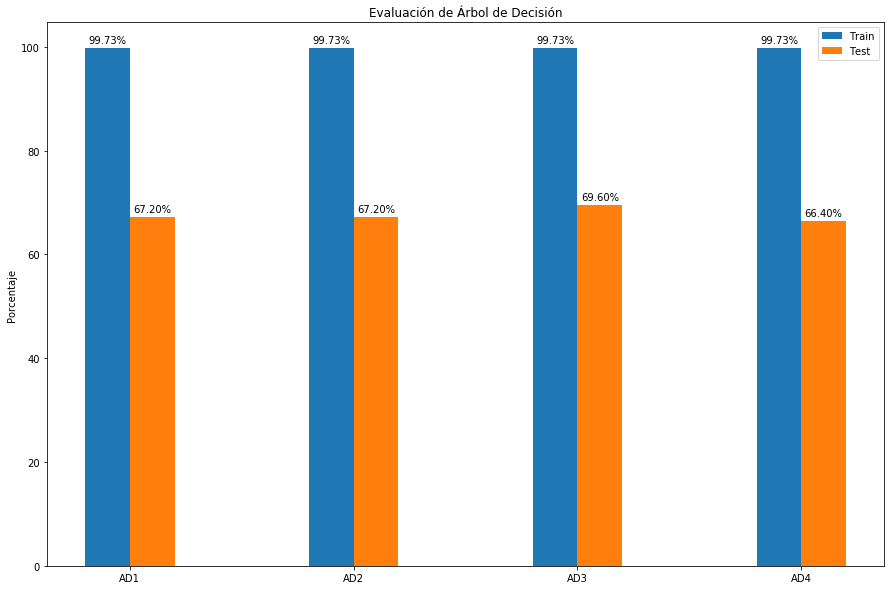

In [37]:
x = np.arange(len(labels2))  # the label locations
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize = (15, 10))
rects1 = ax.bar(x - width/2, train_means2, width, label='Train')
rects2 = ax.bar(x + width/2, test_means2, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Porcentaje')
ax.set_title('Evaluación de Árbol de Decisión')
ax.set_xticks(x)
ax.set_xticklabels(labels2)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

__¿Hay un clasificador que sea superior al otro? ¿por qué crees que sucede?__

Como podemos apreciar en el gráfico de barras, el mejor clasificador que se generó con `Árboles de Decisión` es el AD3 que  es el código con el que hemos llamado al clasificador con `Bolsa de palabras con TF/IDF con Monogramas` aunque la diferencia para los clasificadores de Árboles de Decisión es pequeña, pero podemos indicar el orden en el utilizariamos los mismos:

1. AD3: `Bolsa de palabras con TF/IDF con Monogramas`.

2. AD1: `Bolsa de palabras binaria con Monogramas`.

3. AD2: `Bolsa de palabras binaria con Monogramas y Bigramas`.

4. AD4: `Bolsa de palabras con TF/IDF con Monogramas y Bigramas`.


`RESPUESTA PENDIENTE`

### Palabras predominantes en el Árbol de Decisión con bolsa de palabras con TF/IDF y Monogramas

El clasificador a utilizar es el `tree_classifier3`.

In [38]:
def print_topN_features_in_trees(vectorizer, clf, n=20):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names()
    
    topN = np.argsort(clf.feature_importances_)[-n:]
    reversed_top = topN[::-1]
    print("Top {} features in the tree\n".format(n))
    print("%s" % ( " ".join(feature_names[j] for j in reversed_top)))

print_topN_features_in_trees(vectorizer,tree_classifier3,15)

Top 15 features in the tree

great good delicious best place nice amazing love friendly awesome excellent fantastic time perfect vegas


__¿Predominan más las palabras de uno u otro sentimiento? ¿por qué? ¿hay ruido?__

Hemos observado que predominan las palabras con sentimiento positivo, esto se debe a que el clasificador ha sobreaprendido reglas y busca pequeñas diferencias para decicir el sentimiento presente en el texto.

Por otra parte, podemos observar que en el existe ruido con palabras como **place**, **time** y **vegas**.

### Palabras predominantes en Naive Bayes con bolsa de palabras con TF/IDF con Monogramas y Bigramas.

El clasificador a utilizar es el `mnb_classifier4`.

In [39]:
def print_topN_features_per_class_in_NB(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top {} features per class\n".format(n))
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.feature_log_prob_[i])[-n:]
        reversed_top = topN[::-1]
        
        print("%s:   %s" % (class_label,
              " ".join(feature_names[j] for j in reversed_top)),'\n')

class_labels = ["Malo","Bueno"]
print_topN_features_per_class_in_NB(vectorizer4,mnb_classifier4,class_labels, 15)  

Top 15 features per class

Malo:   food place service don won like bad time good think probably did eating minutes going 

Bueno:   great good place food service delicious awesome amazing love friendly best nice really time just 



__¿Tienen sentido las palabras seleccionadas? ¿hay ruido (palabras sin sentimiento o de sentimiento opuesto al esperado)? ¿por qué crees que suceden estos fenómenos?__

Como podemos observar en las listas anteriores, hay palabras que no tienen sentido como por ejemplo **food** que se encuentra en ambas listas.

Además, si miramos el contenido de cada lista, podemos decir que:

- Para las palabras que clasifican un texto como malo, solo encontramos dos palabras que pueden indicar que realmente es malo: **bad** y **probably**.

- Sin embargo, para las palabras que clasifican un texto como bueno, la mayoria de las palabras indican que buenos sentimientos, aunque se tienen algunas que son ruido como **place**, **food**, **service**, **really**, **time** y **just**.

Esto puede suceder porque el clasificador este sobreaprendiendo y busque pequeñas diferencias para clasificar los textos.

# Apartado B.

Gracias a las observaciones y deducciones realizadas anteriormente podemos darnos cuenta que el **mejor clasificador Naive Bayes es el NB4** y el **mejor arbol de decisión es el AD3.**

In [42]:
#Imports necesarios
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree # Pintando árboles con sckit-learn

## **Análisis de la precisión y exhaustividad de los mejores clasificadores**

In [51]:
mnb_classifier = mnb_classifier4
mnb_predictions = mnb_test_predictions4

#Sin necesidad de modificar el dataset podemos asignar 0 para "negativa" y 1 para "positiva".
print(classification_report(test[1], mnb_predictions, target_names=["Negativa", "Positiva"]))

              precision    recall  f1-score   support

    Negativa       0.84      0.72      0.77       128
    Positiva       0.74      0.85      0.79       122

    accuracy                           0.78       250
   macro avg       0.79      0.79      0.78       250
weighted avg       0.79      0.78      0.78       250



**¿Tiene un comportamiento homogéneo a la hora de clasificar ambas clases?**

**¿Cuáles son sus fortalezas y debilidades?**

In [52]:
tree_classifier = tree_classifier3
tree_predictions = tree_test_predictions3

#Sin necesidad de modificar el dataset podemos asignar 0 para "negativa" y 1 para "positiva".
print(classification_report(test[1], tree_predictions, target_names=["Negativa", "Positiva"]))

              precision    recall  f1-score   support

    Negativa       0.69      0.75      0.72       128
    Positiva       0.71      0.64      0.67       122

    accuracy                           0.70       250
   macro avg       0.70      0.69      0.69       250
weighted avg       0.70      0.70      0.69       250



**¿Tiene un comportamiento homogéneo a la hora de clasificar ambas clases?**

**¿Cuáles son sus fortalezas y debilidades?**

## **Árbol de decisión** 

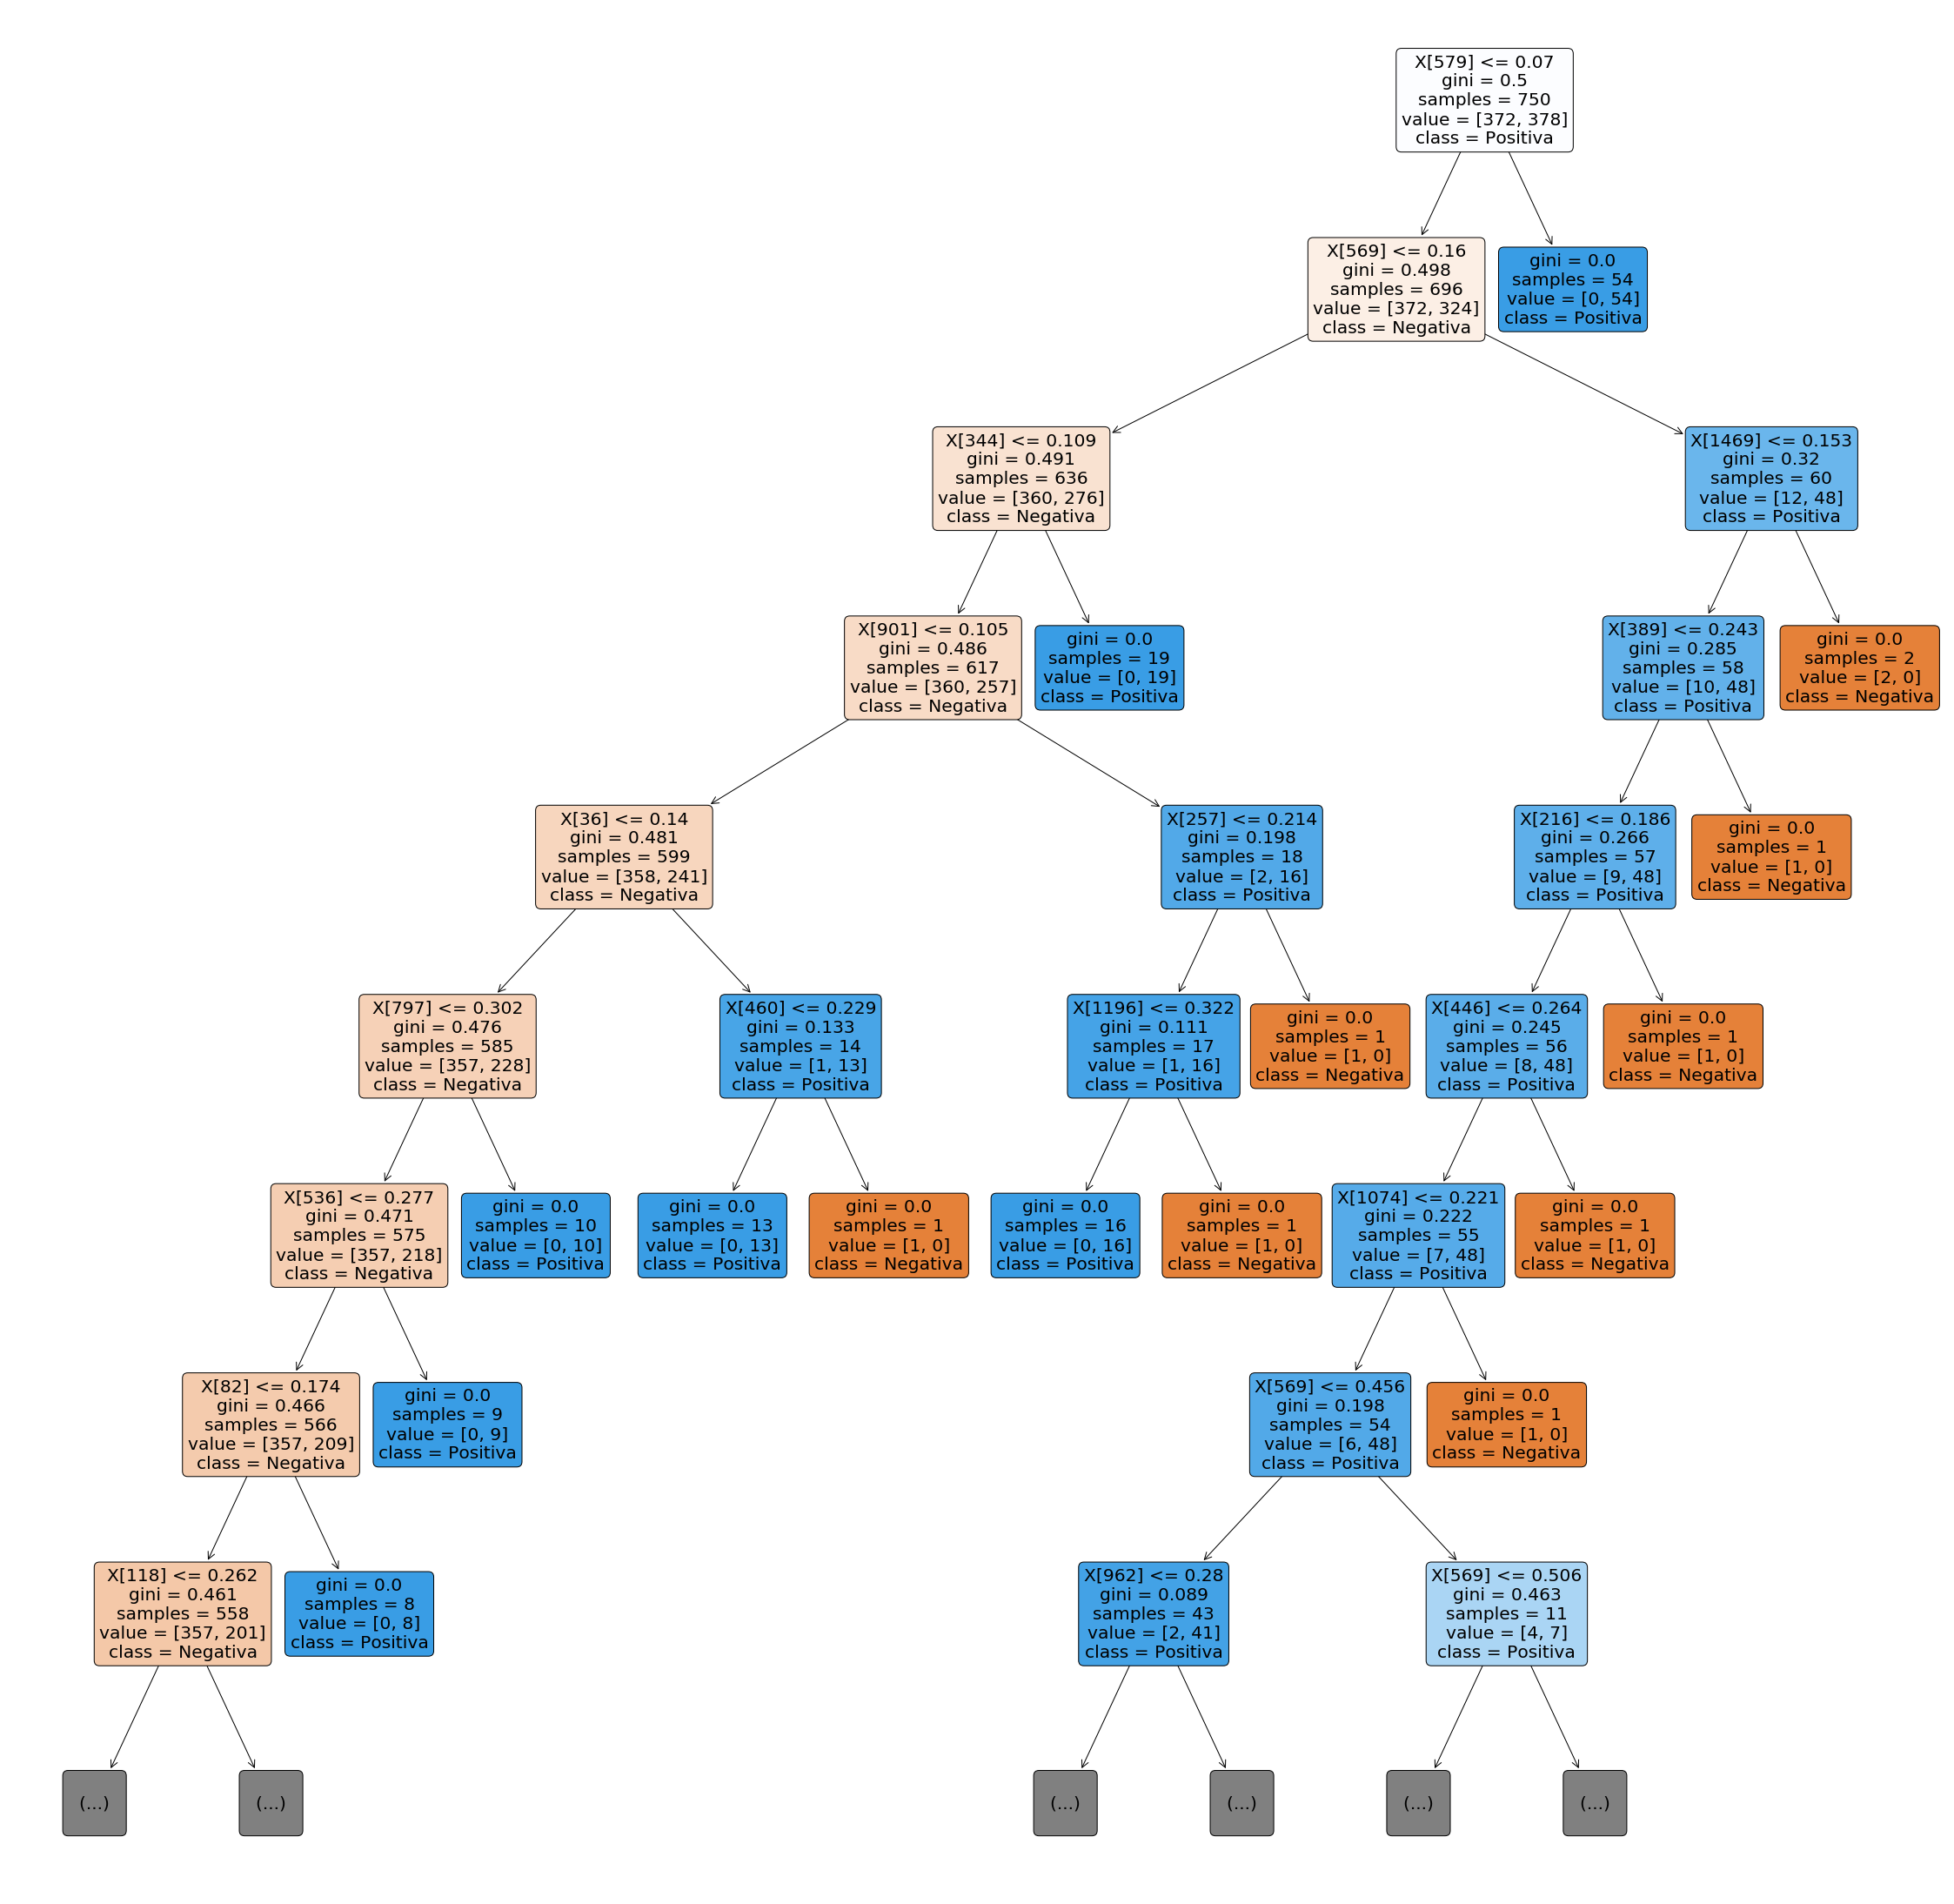

In [53]:
# Vamos a mostrar el árbol de decisión generado usando plot_tree
plt.figure(figsize=(40,40))
plot_tree(tree_classifier, filled=True, class_names=["Negativa", "Positiva"], rounded=True, max_depth=8)
plt.show()

**¿Qué estructura tiene el árbol?**

**¿Cómo interpretas los niveles que has pintado? ¿tienen algún sentido con respecto a la tasa de aciertos, o la precisión y exhaustividad del clasificador?**

**¿Hay nodos impuros?**

## Clasificador Naive Bayes

**Críticas que han sido falsas positivas (malas críticas calificadas como buenas)**

In [55]:
test[1].values

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0], dtype=int64)

In [54]:
mnb_predictions

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

**¿Por qué crees que ha fallado el clasificador en cada uno de los casos?**

**¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?**


**Críticas que han sido falsas negativas (buenas críticas clasificadas como malas)**

**¿Por qué crees que ha fallado el clasificador en cada uno de los casos?**

**¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?**


## Clasificador árbol de decisión

**Críticas que han sido falsas positivas (malas críticas calificadas como buenas)**

In [56]:
test[1].values

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0], dtype=int64)

In [57]:
tree_predictions

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

**¿Por qué crees que ha fallado el clasificador en cada uno de los casos?**

**¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?**


**Críticas que han sido falsas negativas (buenas críticas clasificadas como malas)**

**¿Por qué crees que ha fallado el clasificador en cada uno de los casos?**

**¿Se te ocurre alguna idea sobre cómo mejorar el clasificador de sentimiento?**